In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
sys.path.append('../common')
import collect_dem

In [3]:
fault_data = open('landers_fault', 'r').read()

rows = fault_data.split('\n')
raw_fault_segs = []
for r in rows:
    if len(r) == 0:
        continue
    cols = r.split(' ')
    segment_name = ''
    for c_idx in range(len(cols)):
        if cols[c_idx][0].isalpha():
            segment_name += cols[c_idx] + ' '
        else:
            break
    lat = float(cols[c_idx])
    lon = float(cols[c_idx + 1])
    length_km = float(cols[c_idx + 2])
    azimuth_deg_ccw_from_east = float(cols[c_idx + 3])
    slip_cm = float(cols[c_idx + 4])
    raw_fault_segs.append((segment_name, lat, lon, length_km, azimuth_deg_ccw_from_east, slip_cm))

In [4]:
from pyproj import Geod
g = Geod(ellps = 'WGS84')
fault_edges = []
for s in raw_fault_segs:
    center_lat = s[1]
    center_lon = s[2]
    length_m = 0.5 * s[3] * 1000
    az_from_n = -90 - s[4]
    start_lon, start_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, -length_m)
    end_lon, end_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, length_m)
    fault_edges.append(np.array([[start_lat, start_lon], [end_lat, end_lon]]))
fault_edges = np.array(fault_edges)

In [5]:
pts = np.fliplr(fault_edges.reshape((-1, 2)))
els = np.arange(pts.shape[0]).reshape((-1, 2))
m = (pts, els)

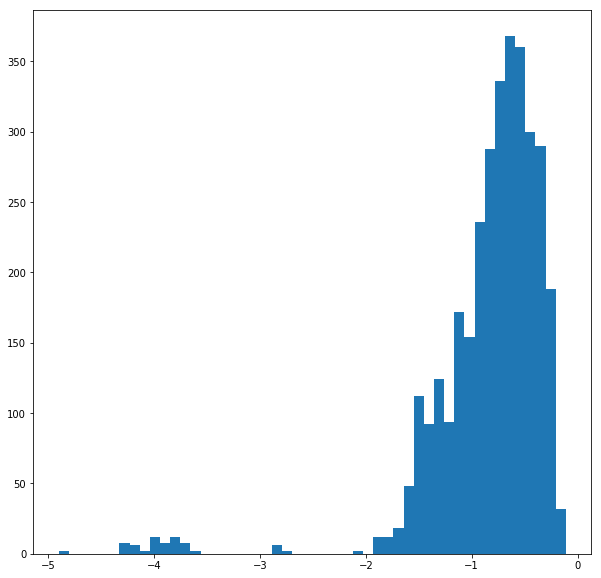

In [6]:
import scipy.spatial.distance
def plot_distance_distribution(m):
    dist = scipy.spatial.distance.cdist(m[0], m[0])
    %matplotlib inline
    plt.figure(figsize = (10,10))
    plt.hist(np.log10(np.abs(dist[dist > 0])), bins = 50)
    plt.show()
plot_distance_distribution(m)

number of remaining pts: 31


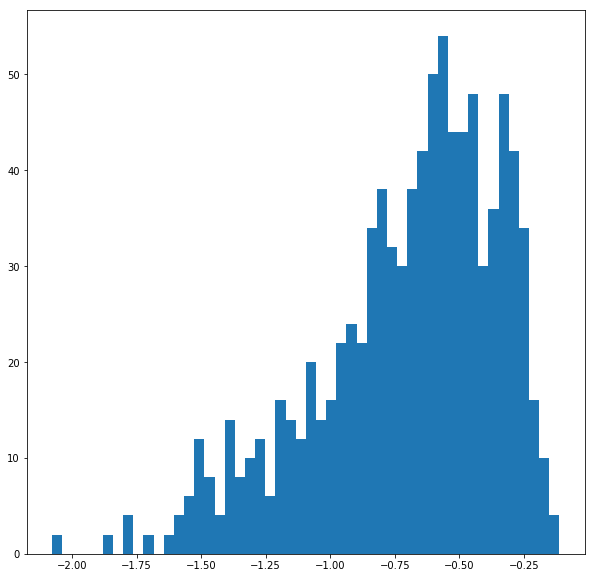

In [7]:
from tectosaur.mesh.modify import remove_duplicate_pts
m_combined = remove_duplicate_pts(remove_duplicate_pts((pts, els), 6e-3), 5e-3)
print('number of remaining pts: ' + str(m_combined[0].shape[0]))
plot_distance_distribution(m_combined)

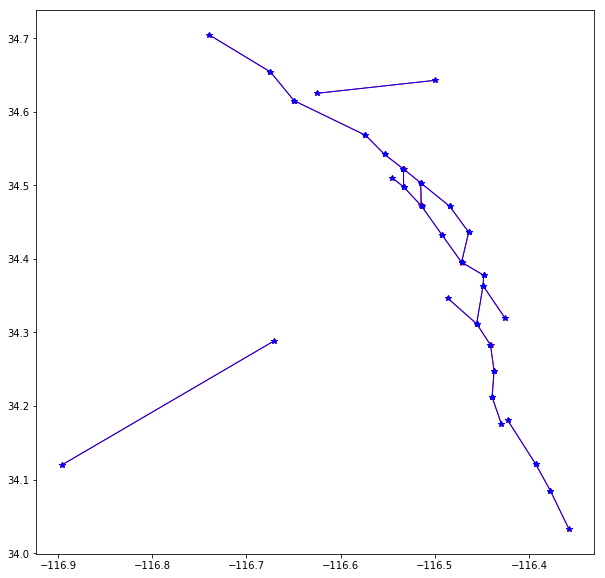

In [8]:
%matplotlib inline
plt.figure(figsize = (10, 10))
for plot_mesh, color in [(m, 'r'), (m_combined, 'b')]:
    for i in range(plot_mesh[1].shape[0]):
        el_pts = plot_mesh[0][plot_mesh[1][i,:]]
        plt.plot(el_pts[:,0], el_pts[:,1], color + '-*', linewidth = 1.0)
plt.show()

In [9]:
def refine_to_size2d(m, threshold):
    pts, els = m
    new_pts = pts.tolist()
    new_els = []
    for i, e in enumerate(els):
        e_pts = pts[e]
        L = np.sqrt(np.sum((e_pts[1,:] - e_pts[0,:]) ** 2))
        split_factor = int(np.ceil(L / threshold))
        xhats = np.linspace(0.0, 1.0, split_factor + 1)
        pts_to_add = (e_pts[0,:,np.newaxis] * (1 - xhats[1:-1]) + e_pts[1,:,np.newaxis] * xhats[1:-1]).T
        start_idx = len(new_pts)
        new_pts.extend(pts_to_add.tolist())
        for i in range(split_factor):
            left_idx = e[0] if i == 0 else start_idx + i - 1
            right_idx = e[1] if i == split_factor - 1 else start_idx + i
            new_els.append((left_idx, right_idx))
    return (np.array(new_pts), np.array(new_els))

m_refined = refine_to_size2d(m_combined, 0.03)

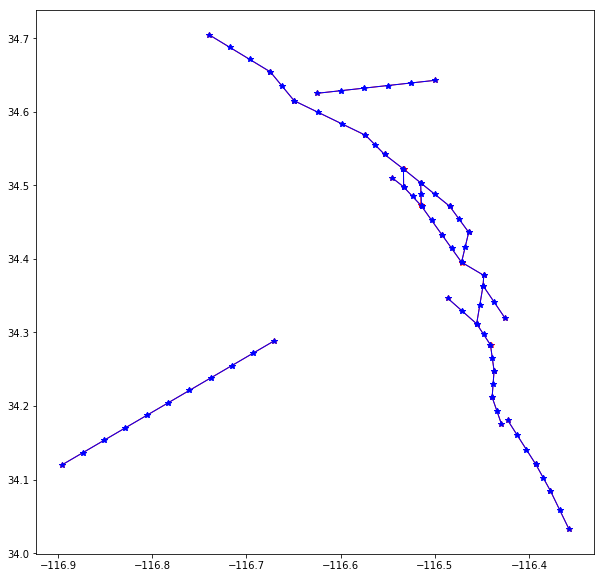

In [10]:
plt.figure(figsize = (10, 10))
for plot_mesh, color in [(m, 'r'), (m_refined, 'b')]:
    for i in range(plot_mesh[1].shape[0]):
        el_pts = plot_mesh[0][plot_mesh[1][i,:]]
        plt.plot(el_pts[:,0], el_pts[:,1], color + '-*', linewidth = 1.0)
plt.show()

In [11]:
surf_center = np.mean(m_refined[0], axis = 0)
fault_L = np.max(np.sqrt(np.sum((m_refined[0] - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 5
surf_center, fault_L

(array([-116.54857618,   34.37953685]), 0.43390345837679278)

In [12]:
import pygmsh
geom = pygmsh.built_in.Geometry()

w = fault_L * 4
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
for edge in m_refined[1]:
    for j in range(2):
        if edge[j] not in gmsh_pts:
            pt = m_refined[0][edge[j]].tolist()
            pt.append(0)
            gmsh_pts[edge[j]] = geom.add_point(pt, mesh_size)
    line = geom.add_line(gmsh_pts[edge[0]], gmsh_pts[edge[1]])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

In [13]:
points, cells, pt_data, cell_data, field_data = pygmsh.generate_mesh(
    geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0
)
surf_m = (points, cells['triangle'])

Info    : Running 'gmsh -2 -bin /tmp/tmpo2a_wyv2.geo -o /tmp/tmpgq0w9a54.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Tue Nov 28 18:21:47 2017
Info    : Reading '/tmp/tmpo2a_wyv2.geo'...
Info    : Done reading '/tmp/tmpo2a_wyv2.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve

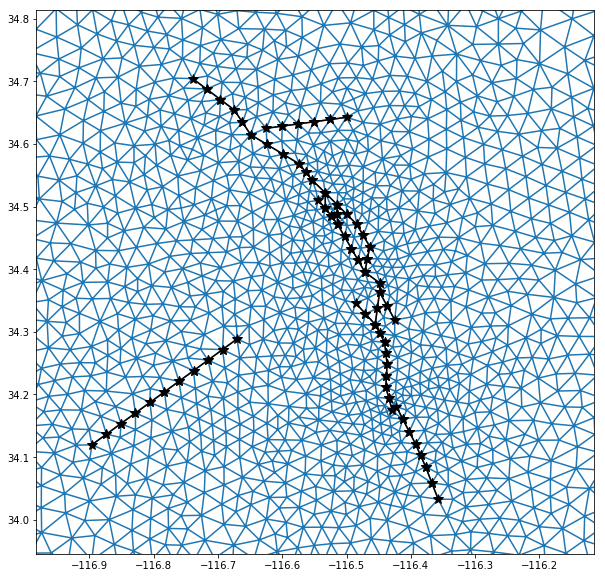

In [14]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'])
for edge in m_refined[1]:
    pts = m_refined[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'k-*', markersize = 10)
vW = 1 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

In [15]:
zoom = 5
n_dem_interp_pts = 300
proj = 'utm11S'

In [16]:
fault_pts_proj = collect_dem.project(m_refined[0][:,0], m_refined[0][:,1], 0 * m_refined[0][:,0], proj)
m_proj = (fault_pts_proj, m_refined[1])
surf_pts_proj = collect_dem.project(surf_m[0][:,0], surf_m[0][:,1], surf_m[0][:,2], proj)
surf_proj = (surf_pts_proj, surf_m[1])

11S
11S


In [19]:
fault_chunks = []
depth = 15000
from tectosaur.mesh.mesh_gen import make_rect
for edge in m_proj[1]:
    edge_pts = m_proj[0][edge]
    edge_L = np.linalg.norm(edge_pts[1] - edge_pts[0])
    bottom_left = edge_pts[0].copy()
    bottom_right = edge_pts[1].copy()
    bottom_left[2] = -depth
    bottom_right[2] = -depth
    n_vertical = int(np.ceil(depth / edge_L))
    corners = np.array([edge_pts[0], bottom_left, bottom_right, edge_pts[1]])
    fault_chunks.append(make_rect(n_vertical, 2, corners))
from tectosaur.mesh.modify import concat
full_fault_mesh = concat(*fault_chunks)

full_fault_mesh[0].shape[0], sum([f[0].shape[0] for f in fault_chunks])

(557, 926)

In [20]:
from tectosaur.mesh.combined_mesh import CombinedMesh
full_m = CombinedMesh.from_named_pieces([('surf', surf_proj), ('fault', full_fault_mesh)])

In [21]:
# def get_mesh_sphere(pts):
#     C = np.mean(pts, axis = 0)
#     L = np.max(np.sqrt(np.sum((pts - C) ** 2, axis = 1)))
#     return C, L

# def plt_lims_CL(C, L, view_factor):
#     vW = view_factor * L
#     plt.xlim([C[0] - vW, C[0] + vW])
#     plt.ylim([C[1] - vW, C[1] + vW])
    
# plt.figure(figsize = (10, 10))
# plt.triplot(full_m.pts[:,0], full_m.pts[:,2], full_m.tris)
# C, L = get_mesh_sphere(full_m.pts[full_m.get_tris('fault')].reshape((-1,3))) 
# plt_lims_CL([C[0], C[2]], L, 2.0)
# plt.ylim([-depth, 0])
# plt.show()
np.save('mesh.npy', (full_m.pts, full_m.tris))

In [31]:
def set_surf_elevations(m, n_dem_interp_pts, zoom, proj):
    surf_pt_idxs = m.get_pt_idxs('surf')
    lonlat_pts = collect_dem.project(m.pts[:,0], m.pts[:,1], m.pts[:,2], proj, inverse = True)
    bounds = collect_dem.get_dem_bounds(lonlat_pts)
    print(bounds)
    proj_dem = collect_dem.project(*collect_dem.get_dem(zoom, bounds, n_dem_interp_pts), proj)
    import copy
    new_m = copy.copy(m)
    new_m.pts[surf_pt_idxs,2] = scipy.interpolate.griddata(
        (proj_dem[:,0], proj_dem[:,1]), proj_dem[:,2],
        (m.pts[surf_pt_idxs,0], m.pts[surf_pt_idxs,1])
    )
    return new_m

import mesh_fncs
def plot_situation(m, view_R = 2.0):
    fault_pts = m.pts[m.get_tris('fault')].reshape((-1,3))
    fC = np.mean(fault_pts, axis = 0)
    R = np.sqrt(np.max(np.sum((fault_pts - fC) ** 2, axis = 1)))
    
    surf_pts = m.pts[m.get_tris('surf')]
    levels = np.linspace(np.min(surf_pts[:,:,2]), np.max(surf_pts[:,:,2]), 16)

    plt.figure(figsize = (13, 13))
    cntf = plt.tricontourf(
        m.pts[:,0], m.pts[:,1], m.get_tris('surf'), m.pts[:,2], 
        levels = levels, extend = 'both'
    )
    fault_tris = m.get_tris('fault')
    for e in mesh_fncs.get_surf_fault_edges(m.get_tris('surf'), fault_tris):
        i1, d1 = e[0]
        i2, d2 = e[1]
        pts = m.pts[[fault_tris[i1,d1], fault_tris[i2,d2]]]
        plt.plot(pts[:,0], pts[:,1], 'k-', markersize = 10)
    plt.triplot(m.pts[:,0], m.pts[:,1], m.get_tris('fault'), 'w-', linewidth = 0.4)
    plt.quiver(data['X'], data['Y'], data['EW'], data['SN'], color = 'r')
    plt.colorbar(cntf)
    plt.xlim([fC[0] - view_R * R, fC[0] + view_R * R])
    plt.ylim([fC[1] - view_R * R, fC[1] + view_R * R])
    plt.show()

ImportError: No module named 'mesh_fncs'

In [28]:
m_with_topo = set_surf_elevations(full_m, n_dem_interp_pts, zoom, proj)

11S
(32.296800248270713, -118.63131277534977, 36.462273448687959, -114.46583957493255)
5 5 12
11S


NameError: name 'mesh_fncs' is not defined

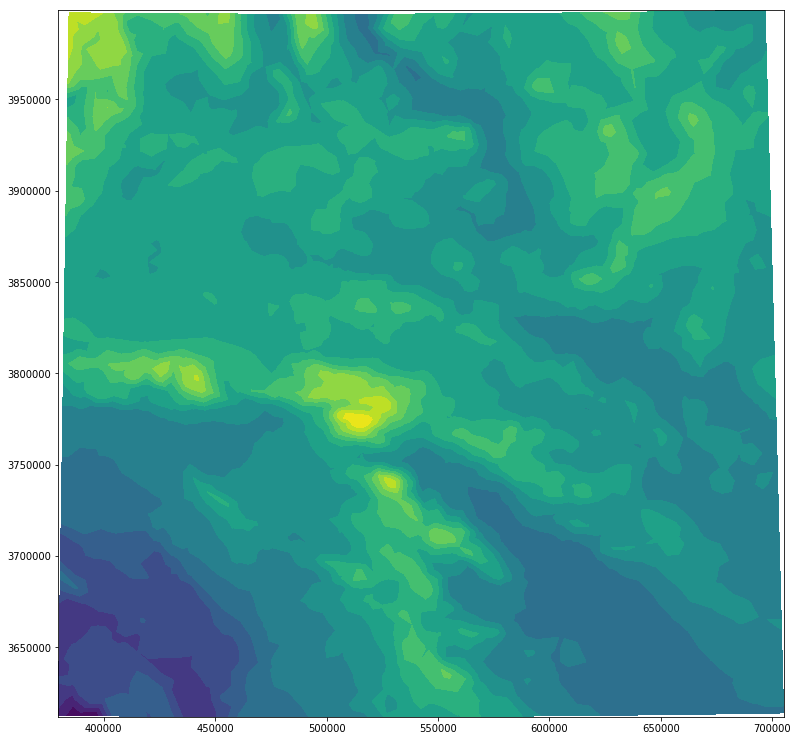

In [30]:
plot_situation(m_with_topo, view_R = 2.0)

In [17]:
bounds = collect_dem.get_dem_bounds(points)
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)
plt.plot(LON, LAT, 'r.')
plt.plot(points[:,0], points[:,1], 'b.')
plt.show()

5 5 12


URLError: <urlopen error [Errno -2] Name or service not known>

In [20]:
fault_pt_elevations = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (m_combined[0][:,0], m_combined[0][:,1])
)
vertical_diff = fault_pt_elevations - m_combined[0][:,2]
below_surf = np.abs(vertical_diff) >= 800
above_surf = np.logical_not(below_surf)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
surf_m[0][:,2] = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (surf_m[0][:,0], surf_m[0][:,1])
)
m_combined[0][refined_above_surf,2] = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (m_combined[0][refined_above_surf,0], m_combined[0][refined_above_surf,1])
)